## This is the code kindly shared by J. Self, first author of the paper:
#### Self, J.; Bergstrom, H. K. Hypoeutectic Liquid-Solid Phase Diagrams for Ternary Lithium-Ion Battery Electrolytes. Journal of Physical Chemistry Letters 2024, 15 (2), 416-421, Article. DOI: 10.1021/acs.jpclett.3c03169.


In [19]:
# Simplified code for JPCL paper (draft) for Ruihe Li - JS 2024-02-13
import numpy as np, matplotlib.pyplot as plt, pandas as pd, scipy
from scipy import stats,integrate
# Where am I?
#!pwd
#!ls
#
plt.rc('font', size=12)
import pandas

In [20]:
###### 1) global variables ######
#################################
T0EC,T0EMC,R=273.15+38.05,273.15+-53.8,8.31
MolarMassSolvent1,MolarMassSolvent2=0.088,0.104
HfusEC,HfusEMC=13020,11240 # J/mol (ding) # J/mol (ding)
#### Fitted ####
C12global,C112global,C122global=[2.7936,-7.8747,1.7636] # model
######numerical variables####
nopoints=200000
###### functions #########
def diff_central(a, b):
    xdc0,xdc1,xdc2 = a[:-2],a[1:-1],a[2:]
    ydc0,ydc1,ydc2 = b[:-2],b[1:-1],b[2:]
    fdc = (xdc2 - xdc1)/(xdc2 - xdc0)
    return (1-fdc)*(ydc2 - ydc1)/(xdc2 - xdc1) + fdc*(ydc1 - ydc0)/(xdc1 - xdc0)
#############

In [21]:
######## 2) Activities of EC ##########################
######################## EC - LiPF6 ###########################
def a32(m2,C2=0,C22=  -0.2791617  ,C222= 0 ,C2222= -0.0191328):
    temp=(1-(2*m2)/(2*m2+1/MolarMassSolvent1))*np.exp(C2*m2**1.5+C22*m2**2+C222*m2**2.5+C2222*m2**3)
    return(temp)
########################### EC - EMC ##########################
def a31(X1,C1,C11,C111,C1111): # EC EMC
    temp=(1-X1)*np.exp(C1*X1**2+C11*X1**3+C111*X1**4)
    return(temp)
########### 3)  Fitting Activities of EMC ###################
####################### EMC - LiPF6 $########################
plt.figure(1),plt.figure(figsize=(4, 2)) 
def a12(m2,C2=0.8262921,C22= -1.79133566 ,C222= 1.70109032 ,C2222= -0.63441192):
    temp=(1-(2*m2)/(2*m2+1/MolarMassSolvent2))*np.exp(C2*m2**1.5+C22*m2**2+C222*m2**2.5+C2222*m2**3)
    return(temp)
################################## parametrized ##################################
def a13(X1,C1,C11,C111,C1111): # EMC EC
    temp=(1-X1)*np.exp(C1*X1**2+C11*X1**3+C111*X1**4) #three suffix Margules
    return(temp)

<Figure size 640x480 with 0 Axes>

<Figure size 400x200 with 0 Axes>

In [22]:
################################################################
########### 4) Establishing mixing rules #######################
################################################################
########### binary global parameters ###########################
C1ECEMC,C11ECEMC,C111ECEMC,C1111ECEMC=-0.66992,4.2840,-2.5671,0
C1EMCEC,C11EMCEC,C111EMCEC,C1111EMCEC=0.62190,2.5617,-2.5672,0
C2ECLiPF6global,C22ECLiPF6global,C222ECLiPF6global,C2222ECLiPF6global=0.042895,-0.38832,0.066300,-0.017292 # EC-LiPF6 #
C2EMCLiPF6global,C22EMCLiPF6global,C222EMCLiPF6global,C2222EMCLiPF6global=0.8262921,-1.79133566,1.70109032,-0.63441 #EMC-LiPF6#
#########################################################################################
def a3simplified(m2,X1,C12=C12global,C112=C112global,C122=C122global,X3=0,alpha=0): # aEC 
    X1solventratio=X1/(X1+X1*alpha)
    X3test=X1*alpha
    X2=1-X1-X3test
    aitern=X3test
    aitern*=a32(
        m2,C2=C2ECLiPF6global,C22=C22ECLiPF6global,
        C222=C222ECLiPF6global,C2222=C2222ECLiPF6global
        )/(1-(2*m2)/(2*m2+1/MolarMassSolvent1))
    aitern*=a31(
        X1solventratio,C1ECEMC,C11ECEMC,
        C111ECEMC,C1111ECEMC
        )/(1-X1solventratio)
    aitern*=np.exp(
        C12*m2**1.5*X1solventratio**2
        +C112*m2**1.5*X1solventratio**3
        +C122*m2**2*X1solventratio**2)
    return(aitern)#
def a1simplified(m2,X3,alpha=0): # aEMC   # alpha = X_EC/X_EMC
    # X3solventratio=X3*alpha/(X3*alpha+X3) # X3 here should be X_EC? initial version
    X3solventratio=X3/(X3*alpha+X3) # X3 here should be X_EC? # Mark Ruihe
    X1test=X3/(alpha+1E-16)               # X1test should be X_EMC here?
    X2=1-X3-X1test
    aitern=X1test
    aitern*=a12(
        m2,C2=C2EMCLiPF6global, C22=C22EMCLiPF6global, 
        C222=C222EMCLiPF6global, C2222=C2222EMCLiPF6global
        )/(1-(2*m2)/(2*m2+1/MolarMassSolvent2))
    aitern*=a13(
        X3solventratio,C1EMCEC,C11EMCEC,
        C111EMCEC,C1111EMCEC
        )/(1-X3solventratio)
    return(aitern)

In [23]:
####  TD Factor function (eq 10) ####
def calculatedTDfactor(x,C12test,C112test,C122test,alpha=1):
    nopoints=100000
    xLiTest=np.linspace(0,0.1,nopoints)
    mEC=1/(MolarMassSolvent1+MolarMassSolvent2/alpha)
    mEMC=mEC/alpha
    mLiTest=(mEC+mEMC)*xLiTest/(1-2*xLiTest) # mEC+mEMC
    xEMCtest=mEMC/(mEMC+mEC+2*mLiTest)
    xECtest=mEC/(mEC+mEMC+2*mLiTest)
    aEC=a3simplified(mLiTest,xEMCtest,alpha=alpha)
    aEMC=a1simplified(mLiTest,xECtest,alpha=alpha)
    mU,m1=mEMC,mEC
    tempGD=-mEMC*np.log(aEMC[:]/aEMC[0])-mEC*np.log(aEC[:]/(aEC[0]))
    calculatedTDfactorRETURN=diff_central(mLiTest[4:],tempGD[:-4]/2)
    return(mLiTest[2+4:],calculatedTDfactorRETURN)
x11,yTDF11=calculatedTDfactor(0,0,0,0,alpha=1.18)
x10,yTDF10=calculatedTDfactor(0,0,0,0,alpha=10000)
x01,yTDF01=calculatedTDfactor(0,0,0,0,alpha=0.00001)

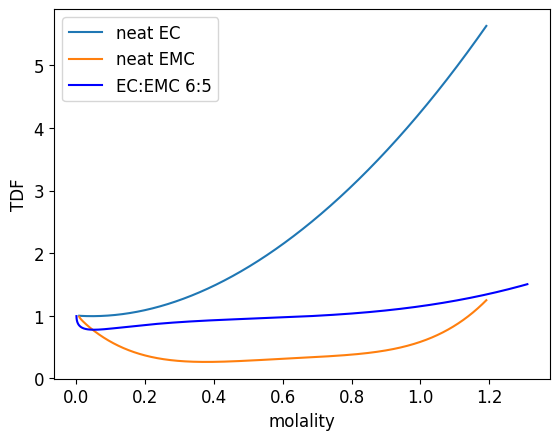

In [24]:
plt.plot(np.sqrt(x10),yTDF10,label="neat EC")
plt.plot(np.sqrt(x10),yTDF01,label="neat EMC")
plt.plot(x11,yTDF11,'b',label="EC:EMC 6:5")
plt.xlabel("molality")
plt.ylabel("TDF")
plt.legend()